# dataset/ingest

In [1]:
import os
from tqdm import *
from abcli import file
from abcli.modules import objects
from abcli import fullname
from abcli.plugins import cache
from roofAI.semseg.utils import visualize
from roofAI.dataset import RoofAIDataset, DatasetKind, MatrixKind
from roofAI.dataset.ingest.AIRS import ingest_AIRS
from roofAI.semseg.model import chip_width, chip_height
from IPython.display import Image
from roofAI import NAME, VERSION
from abcli import string
from abcli.plugins import seed
import numpy as np

import abcli.logging
import logging

logger = logging.getLogger()

logger.info(f"{fullname()}, built on {string.pretty_date()}")

Found credentials in shared credentials file: ~/.aws/credentials
/usr/local/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
abcli-7.2383.1-2023-06-aws-batch-a, built on 21 October 2023, 14:48:19


In [2]:
cache_object_name = cache.read("roofAI_ingest_AIRS_cache")
ingest_object_name=objects.unique_object("roofAI-AIRS-ingest")

📂 roofAI-AIRS-ingest-2023-10-21-14-48-20-95252


In [3]:
cache_object_path = objects.object_path(cache_object_name)
ingest_object_path = objects.object_path(ingest_object_name)

In [4]:
counts = {
    "test": 10,
    "train": 10,
    "val": 10
}

log=True

In [5]:
chip_overlap = 0.5

In [6]:
assert ingest_AIRS(
    cache_path=cache_object_path,
    ingest_path=ingest_object_path,
    counts=counts,
    log=log,
)

ingesting AIRS roofAI_ingest_AIRS_cache_2023-10-15-15-53-41-09195 -test X 10 + train X 10 + val X 10-360x480-@50%-> roofAI-AIRS-ingest-2023-10-21-14-48-20-95252
wip


In [7]:
cache_dataset = RoofAIDataset(cache_object_path)
ingest_dataset = RoofAIDataset(ingest_object_path, kind=DatasetKind.CAMVID).create(log=log)

RoofAIDataset[kind:DatasetKind.AIRS,source:AIRS](roofAI_ingest_AIRS_cache_2023-10-15-15-53-41-09195): 3 subset(s): 95 X test + 857 X train + 94 X val - 2 class(es): other, roof
RoofAIDataset[kind:DatasetKind.CAMVID,source:AIRS](roofAI-AIRS-ingest-2023-10-21-14-48-20-95252): 3 subset(s): 0 X test + 0 X train + 0 X val - 2 class(es): other, roof
abcli.path.create(/Users/kamangir/storage/abcli/roofAI-AIRS-ingest-2023-10-21-14-48-20-95252/SegNet-Tutorial/CamVid/test)
abcli.path.create(/Users/kamangir/storage/abcli/roofAI-AIRS-ingest-2023-10-21-14-48-20-95252/SegNet-Tutorial/CamVid/testannot)
abcli.path.create(/Users/kamangir/storage/abcli/roofAI-AIRS-ingest-2023-10-21-14-48-20-95252/SegNet-Tutorial/CamVid/train)
abcli.path.create(/Users/kamangir/storage/abcli/roofAI-AIRS-ingest-2023-10-21-14-48-20-95252/SegNet-Tutorial/CamVid/trainannot)
abcli.path.create(/Users/kamangir/storage/abcli/roofAI-AIRS-ingest-2023-10-21-14-48-20-95252/SegNet-Tutorial/CamVid/val)
abcli.path.create(/Users/kamangir

In [8]:
def slice_matrix(
    input_matrix: np.ndarray,
    kind: MatrixKind,
    chip_height: int,
    chip_width: int,
    chip_overlap: float,
    max_chip_count: int,
    path: str,
    prefix:str,
    log:bool=False,
) -> int:
    if log:
        logger.info("slice_matrix[{}]: {} -{}X{}x{}-@{:.0f}%-> {} - {}".format(
            string.pretty_shape_of_matrix(input_matrix),
            kind,
            max_chip_count,
            chip_height,
            chip_width,
            chip_overlap * 100,
            path,
            prefix,
        ))

    count = 0
    for y in range(0,input_matrix.shape[0] - chip_height, int(chip_overlap * chip_height)):
        for x in range(0,input_matrix.shape[1] - chip_width, int(chip_overlap * chip_width)):
            count += 1

            chip = input_matrix[
                y:y+chip_height,
                x:x+chip_width
                ]

            assert file.save_image(
                os.path.join(
                    path,
                    "{}-{:05d}-{:05d}.png".format(
                        prefix,
                        y,
                        x,
                    )
                ),
                chip,
                log=log,
            )

            if count >= max_chip_count:
                return count

    return count

In [9]:
log_ = False
for subset in tqdm(counts.keys()):
    for matrix_kind in list(MatrixKind):
        chip_count = counts[subset]
        for record_id in cache_dataset.subsets[subset]:
            input_matrix = cache_dataset.get_matrix(
                subset,
                record_id,
                matrix_kind,
                log=log_,
            )

            chip_count -= slice_matrix(
                input_matrix,
                matrix_kind,
                chip_height,
                chip_width,
                chip_overlap,
                max_chip_count=chip_count,
                path=ingest_dataset.subset_path(subset,matrix_kind),
                prefix=record_id,
                log=log_,
            )

            if chip_count <= 0:
                break

100%|██████████| 3/3 [00:10<00:00,  3.59s/it]


In [10]:
file.save_yaml(
        os.path.join(ingest_dataset.path, "metadata.yaml"),
        {
            "classes": ingest_dataset.classes,
            "kind": "CamVid",
            "source": "AIRS",
            "ingested-by": f"{NAME}-{VERSION}",
        },
        log=True,
    )


abcli.file.save_yaml(/Users/kamangir/storage/abcli/roofAI-AIRS-ingest-2023-10-21-14-48-20-95252/metadata.yaml): classes, kind, source, ingested-by.


True

RoofAIDataset[kind:DatasetKind.CAMVID,source:AIRS](roofAI-AIRS-ingest-2023-10-21-14-48-20-95252): 3 subset(s): 10 X test + 10 X train + 10 X val - 2 class(es): other, roof
record_id: christchurch_424-00000-01680
-> /Users/kamangir/storage/abcli/roofAI-AIRS-ingest-2023-10-21-14-48-20-95252/_review/christchurch_424-00000-01680.png


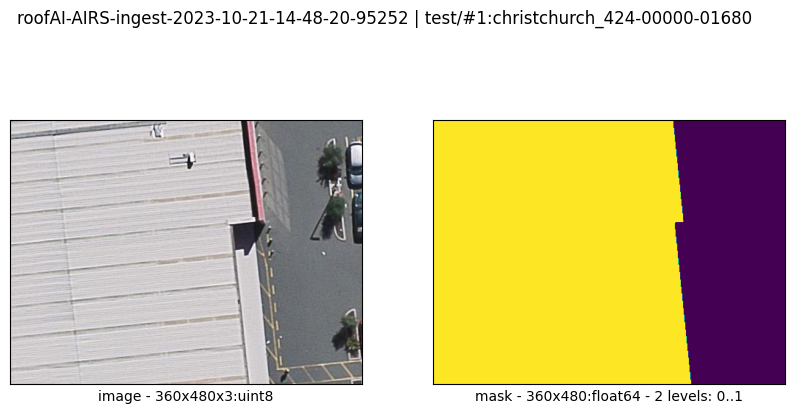

In [11]:
RoofAIDataset(ingest_object_path).visualize(
    subset="test",
    index=1,
    in_notebook=True)

In [12]:
seed.log(ingest_object_path)

abcli select /Users/kamangir/storage/abcli/roofAI-AIRS-ingest-2023-10-21-14-48-20-95252; open .


In [13]:
# END